In [1]:
import pandas, numpy, matplotlib, matplotlib.pyplot as plt, seaborn, datetime, matplotlib.cm as cm
import math, matplotlib.colors as colors
from matplotlib import gridspec

In [2]:
# Parâmetros para dados

DATA_PATH = "../Data/all_month.csv"

relevantAttributes = ["depth","mag","latitude","longitude", "nst", "gap", "rms"]

FAULT_DATE          = "2020-04-12"
SAMPLING_FREQUENCY  = "90T" # 90 minutos
TIME_BEFORE_FAULT   = "7D"
TIME_AFTER_FAULT    = "1D"

# Parâmetros para o gráfico
COLORMAP_BEFORE_FAULT = "Greens"
LINE_ALPHA = 0.7
XTICKS_DENSITY = .10
PCP_COLORBAR_RATE = [10,1]
COLORBAR_INTERPOLATION = 'None'

# Estilo gráficos 
matplotlib.style.use('classic')
matplotlib.rcParams['figure.figsize'] = [11, 4]


In [3]:
# Processa os dias de interesse
faultDate = pandas.to_datetime("2020-04-12")
startDate = faultDate - pandas.to_timedelta(TIME_BEFORE_FAULT)
endDate   = faultDate + pandas.to_timedelta(TIME_AFTER_FAULT)

#print(startDate,faultDate,endDate)

In [4]:
# Carrega dados
df = pandas.read_csv(DATA_PATH)

In [5]:
# Organização dados
df.time = pandas.to_datetime(df.time)
df.set_index('time', inplace=True)
df.sort_index(inplace=True)
df = df[relevantAttributes]

In [6]:
def pythonDatetimeToString(datetimeValue):
    return datetimeValue.strftime("%Y-%m-%d %H:%M:%S")
def pandasDatetimeToString(datetimeValue):
    return datetimeValue.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")


In [7]:
#df.loc['2020-04'].plot(subplots=True)
resampledDf = df[startDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S"):endDate.to_pydatetime().strftime("%Y-%m-%d %H:%M:%S")].resample(SAMPLING_FREQUENCY).mean()
# resampledDf.plot(subplots=True)

In [8]:
# Cria uns Fake outlier
resampledDf[pandasDatetimeToString(faultDate):]["mag"]=resampledDf[pandasDatetimeToString(faultDate):]["mag"]+2
resampledDf[pandasDatetimeToString(faultDate):]["depth"]=resampledDf[pandasDatetimeToString(faultDate):]["depth"]-15

In [9]:
# Escalona valores de 0 a 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
resampledDf[resampledDf.columns] = scaler.fit_transform(resampledDf[resampledDf.columns])
#resampledDf.plot(subplots=True)

In [10]:
y  = resampledDf.values
x = [a for a in range(0,len(resampledDf.columns))]


In [11]:


def createColormapSequence(colormap, baseList, outliersCount):
    norm = colors.Normalize(vmin=min(baseList), vmax=max(baseList))
    lineColor = [colormap(norm(x)) for x in baseList]

    lineColor+= [(1,0,0,1)]*outliersCount
    return [norm,lineColor]

#quantas cores sao necessarias
instancesBeforeFault = len(resampledDf[:faultDate])-1 # -1 porque considera eh <=
instancesAfterFault  = len(resampledDf[faultDate:])

#colormap para antes da falha
colormapBeforeFault = plt.get_cmap(COLORMAP_BEFORE_FAULT)

# valores base para as cores
logScale = [math.log10(x) for x in range(1,instancesBeforeFault+1)]
linearScale = [x/(instancesBeforeFault+1) for x in range(1,instancesBeforeFault+1)]
logRevScale = [1-math.log10(x) for x in range(instancesBeforeFault+1,1,-1)]


#
logColormap    = createColormapSequence(colormapBeforeFault,logScale,   instancesAfterFault)
linearColormap = createColormapSequence(colormapBeforeFault,linearScale,instancesAfterFault)
logRevColormap = createColormapSequence(colormapBeforeFault,logRevScale,instancesAfterFault)

In [12]:
def plotPcp(dataframe,lineColor,ax=None):
    
    if ax is None:
        # cria a figura 
        fig = plt.figure()
        ax = plt.gca()

    x = [a for a in range(0,len(dataframe.columns))]

    # Eixos verticais
    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    # Nome/posição dos atributos nos eixos
    ax.set_xticks(x)
    ax.set_xticklabels(relevantAttributes)

    # Remove marcações no eixo Y
    ax.set_yticks([])

    # Remove margens
    ax.set_xlim(x[0], x[-1])
    for i in range(len(y)):
        ax.plot(x,dataframe.iloc[i],color=lineColor[i])

In [13]:
# HORIZONTAL COLORBAR - SE VOLTAR A PRECISAR
#fig, ax = plt.subplots(figsize=(18, 2))
#rgb_array = [(i[0]*255,i[1]*255,i[2]*255) for i in logColormap[1]]


#dateTicksBefore = numpy.linspace(0, instancesBeforeFault, num=int(instancesBeforeFault*XTICKS_DENSITY))
#dateTicksAfter = numpy.linspace(instancesBeforeFault, instancesBeforeFault+instancesAfterFault-1, num=int(instancesAfterFault*XTICKS_DENSITY))

#dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
#dateTicks.astype(int)


#img = numpy.array(rgb_array, dtype=int).reshape((1, len(rgb_array), 3))
#ax.imshow(img, aspect='auto', interpolation='nearest')
#ax.grid(False)

#ax.set_yticks([])
#ax.set_xticks(dateTicks)
#ax.set_xticklabels(resampledDf.iloc[teste].index)
#ax.set_xticklabels(resampledDf.iloc[dateTicks].index, rotation=+90, ha="center")

#plt.show()

In [14]:
def plotVerticalColorbar(labels, lineColor, elementsBeforeFault, elementsAfterFault, ticksDensity, ax):

    # Converte de percentual de RGB para RGB
    rgb_array = [(i[0]*255,i[1]*255,i[2]*255) for i in lineColor]

    # Alinhamento na vertical  
    verticalAlignedData = numpy.array(rgb_array, dtype=int).reshape((len(rgb_array), 1, 3))[::-1]

    # Plota
    ax.imshow(verticalAlignedData, extent=[0, 1, 0, len(rgb_array)], aspect='auto', interpolation=COLORBAR_INTERPOLATION)
    
    # remove grid 
    ax.grid(False)

    # Sem labels na horizontal
    ax.set_xticks([])

    # Labels na vertical

    dateTicksBefore = numpy.linspace(0, elementsBeforeFault, num=int(elementsBeforeFault*ticksDensity))
    dateTicksAfter = numpy.linspace(elementsBeforeFault, elementsBeforeFault+elementsAfterFault-1, num=math.ceil(elementsAfterFault*ticksDensity))

    dateTicks = numpy.append(dateTicksBefore,dateTicksAfter)
    dateTicks = dateTicks.astype(int)

    ax.set_yticks(dateTicks)
    ax.set_yticklabels(numpy.take(labels,dateTicks), rotation=0, ha="left",va = 'center', minor=False)

    # Labels do lado direito da figura    
    ax.yaxis.tick_right()


In [26]:
def completePicture(dataframe, cmap, elementsBeforeFault, elementsAfterFault, title):

    fig = plt.figure()
    
    spec = gridspec.GridSpec(ncols=2, nrows=1,
                            width_ratios=PCP_COLORBAR_RATE)
    
    ax0 = fig.add_subplot(spec[0])
    ax0.title.set_text(title)
    plotPcp(dataframe,cmap,ax0)

    ax1 = fig.add_subplot(spec[1])
    plotVerticalColorbar(dataframe.index.strftime("%m/%d/%Y %H:%M:%S"),cmap, elementsBeforeFault, elementsAfterFault, XTICKS_DENSITY, ax1)

    plt.show()

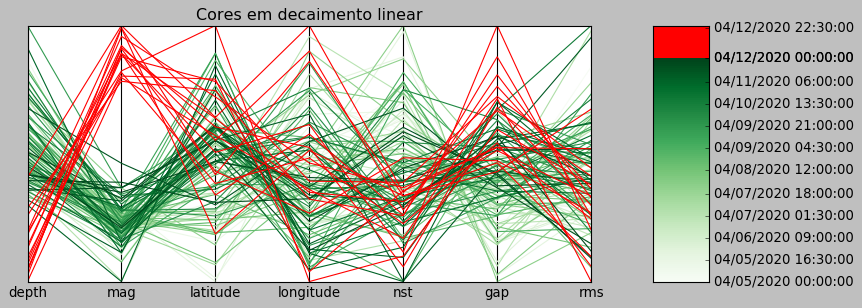

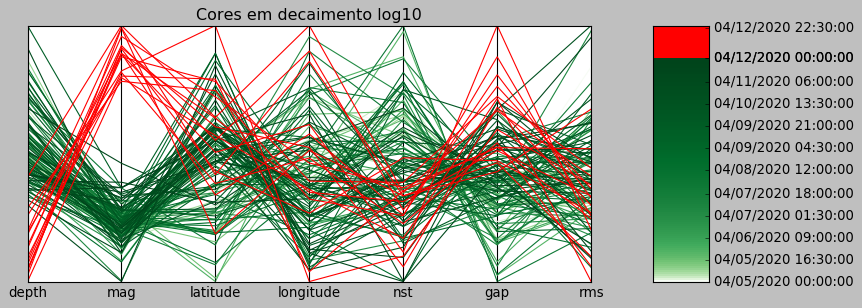

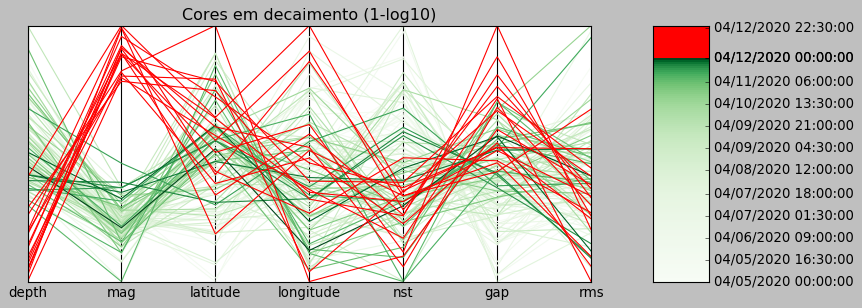

In [27]:
completePicture(resampledDf,linearColormap[1],instancesBeforeFault, instancesAfterFault, "Cores em decaimento linear")
completePicture(resampledDf,logColormap[1],instancesBeforeFault, instancesAfterFault, "Cores em decaimento log10")
completePicture(resampledDf,logRevColormap[1],instancesBeforeFault, instancesAfterFault, "Cores em decaimento (1-log10)")
